In [118]:
import sys
sys.path.append('../src')
import os

import warnings
warnings.simplefilter('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', 100)

import plotly
from plotly import express as ps
import cufflinks
cufflinks.go_offline()

from pathlib import Path

from sklearn.linear_model import Ridge, Lasso, LinearRegression

# PARAMS

In [5]:
PATH = '/home/jovyan/remote_shared_data/dsdiag222/temporary/from_ntc_batching/2020_04_26_2020_06_30_valid_distance_upd.csv'

LINE_PARAMS = {
    'figsize': (25,5)
}

RESAMPLE_FREQ = '10s'

### LOAD DATA

In [4]:
USECOLS = ['time', 'speed', 'car_vin']
%time df = pd.read_csv(PATH, usecols=USECOLS)

CPU times: user 17.3 s, sys: 1.65 s, total: 19 s
Wall time: 44.7 s


In [6]:
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)

### RESAMPLING

In [103]:
df_resampled = df.groupby('car_vin')['speed'].resample(RESAMPLE_FREQ).mean()
df_resampled.replace(0, np.nan, inplace=True)

### ROLLING

In [104]:
ROLLING_FREQ = 6
%time df_rolled = df_resampled.groupby('car_vin').rolling(ROLLING_FREQ).mean()
df_rolled.index = df_rolled.index.droplevel(0)

CPU times: user 4.07 s, sys: 572 ms, total: 4.64 s
Wall time: 4.64 s


### LAGS

In [105]:
%%time

N_LAGS = 6
Y = pd.concat([df_rolled.groupby('car_vin').shift(i) for i in range(N_LAGS)], axis=1)

mask = (Y.isna().sum(axis=1) == 0).values
Y = Y.loc[mask].values.T

CPU times: user 5.04 s, sys: 1.13 s, total: 6.16 s
Wall time: 6.16 s


In [178]:
X = np.arange(N_LAGS).reshape(-1, 1)
%time model = Ridge(1).fit(X, Y)

coef = -1 * model.coef_.flatten()
res = df_rolled.to_frame('speed')
res['coef'] = np.nan
res.loc[mask, 'coef'] = coef

CPU times: user 2.14 s, sys: 1.19 s, total: 3.33 s
Wall time: 616 ms


XTC549015J2519322


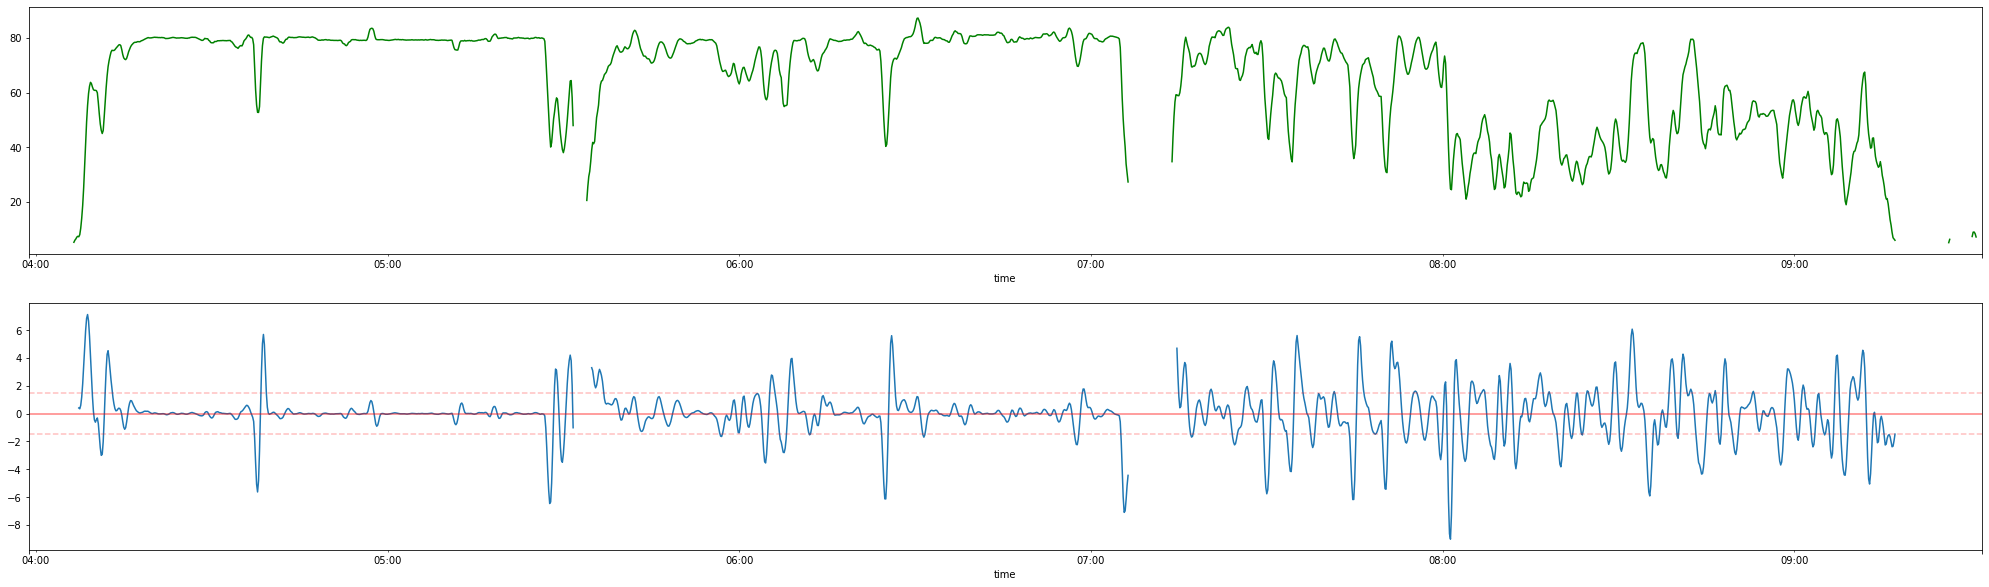

In [179]:
N_HEAD = 2_000
# rand_vin = np.random.choice(df['car_vin'].unique())
print(rand_vin)

##################################################

plt.figure(figsize=(35,10))

plt.subplot(2,1,1)
res.loc[rand_vin, 'speed'].head(N_HEAD).plot(color='green')
plt.subplot(2,1,2)
res.loc[rand_vin, 'coef'].head(N_HEAD).plot()

plt.axhline(y=0, color='r', linestyle='-', alpha=0.5)
plt.axhline(y=-1.5, color='r', linestyle='--', alpha=0.25)
plt.axhline(y=+1.5, color='r', linestyle='--', alpha=0.25)

plt.show()

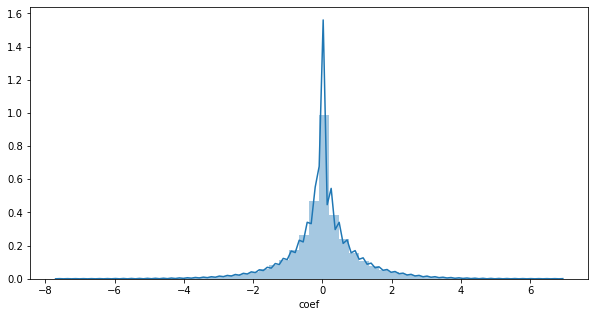

In [69]:
plt.figure(figsize=(10,5))
sns.distplot(df_rolled.loc[mask, 'coef'])

# SEGMENTATION

In [183]:
from sklearn.base import BaseEstimator, ClusterMixin

In [221]:
class TSTrendEstimator(ClusterMixin):
    """
    """
    def __init__(self, rolling_window_size=6, n_lags=6, alpha=1):
        self.rolling_window_size =rolling_window_size
        self.n_lags = n_lags
        self.alpha = alpha
    
    
    def fit_predict(self, X):
        X = X.copy()
        
        
        if isinstance(X.index, pd.core.indexes.multi.MultiIndex):
            multiindex = True
            group_index = X.index.get_level_values(0)
        else:
            multiindex = False
            group_index = None
        
        # rolling window group mean
        
        if multiindex:
            X = X.groupby(group_index).rolling(self.rolling_window_size).mean()
            X.index = X.index.droplevel(0)
            Y = pd.concat([X.groupby(group_index).shift(i) for i in range(self.n_lags)], axis=1)
        else:
            X = X.rolling(self.rolling_window_size).mean()
            Y = pd.concat([X.shift(i) for i in range(self.n_lags)], axis=1)
        
        mask = (Y.isna().sum(axis=1) == 0).values
        Y = Y.loc[mask].values.T
        
        # ridge coef        
        x = np.arange(self.n_lags).reshape(-1, 1)
        model = Ridge(alpha=self.alpha).fit(x, Y)

        coef = -1 * model.coef_.flatten()
        res = X.to_frame('X')
        res['coef'] = np.nan
        res.loc[mask, 'coef'] = coef
        
        return res

In [222]:
%time res = TSTrendEstimator().fit_predict(df_resampled)

CPU times: user 23.8 s, sys: 4.81 s, total: 28.6 s
Wall time: 24.1 s


In [200]:
res = _

In [201]:
Ridge()

speed      coef
car_vin           time                                    
XTC549015J2510673 2020-04-26 06:38:40  82.166667  9.515766
                  2020-04-26 06:38:50  82.000000  6.907658
                  2020-04-26 06:39:00  79.666667  3.805180
                  2020-04-26 06:39:10  76.333333  0.891892
                  2020-04-26 06:39:20  73.208333 -1.256757
...                                          ...       ...
XTC549015L2532712 2020-07-01 13:51:20   2.541667 -0.326577
                  2020-07-01 13:51:30   2.458333 -0.293919
                  2020-07-01 13:51:40   2.708333 -0.185811
                  2020-07-01 13:51:50   2.791667 -0.077703
                  2020-07-01 13:52:00   2.416667 -0.034910

[3968639 rows x 2 columns]